<h1>Stock Value Prediction using external Features</h1>
<h3> Himakar Paradi | Gadu Dinesh Kumar Naidu | Ravi Varma Gottumukkala | Rohith Kankipati </h3>

<h3>Part I: Data Loading</h3>

In [5]:
#importing required Header Files
import numpy as np
import pandas as pd
from keras.layers import LSTM,Dense, Dropout, concatenate
from keras import Model
import keras as keras
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [6]:
#load final1.csv - the file contains stock values for the past 5 years
data = pd.read_csv('data/final1.csv')
data.set_index('Date', inplace=True)
nullcolumns = data.columns[data.isna().any().to_list()].to_list()
data = data.drop(nullcolumns, axis=1)
data.head()

np.max(np.max(data))

539180.0

In [7]:
# split the data into train and test
columns = list(data.columns)
random.shuffle(columns)


testData = data[columns[:50]]
trainData = data[columns[50:]]
print(trainData.shape, testData.shape)

(1463, 331) (1463, 50)


In [8]:
# loading the data file containing external features
data2 = pd.read_csv('data/processedFeatures.csv')
data2.set_index('Date', inplace=True)
nullcolumns = data2.columns[data2.isna().any().to_list()].to_list()
data2 = data2.drop(nullcolumns, axis=1)
data2.head()

def f(x):
  if type(x) == str:
    x = x.replace(",", "")
    return float(x)
  return x

for column in data2.columns:
  data2[column] = data2[column].apply(f)
data2.to_csv("data/processedFeatures.csv")

In [9]:
#The data Processor class helps to process the data into the format which is required for the model
#init function : intializes the class with data and finds requiered parameters like min and max for (min-max) regularization
#transform: normalize data
#inverse_transform : de normalize data
#get_data : it returns the processed data
#get_test_data: processes test data for prediction
class DataProcessor():
    
    def __init__(self, stock_data, feature_data) -> None:
        self.xd = stock_data
        self.zd = feature_data
        self.stock_min = stock_data.min(axis = 0)
        self.stock_max = stock_data.max(axis = 0)
        self.features_min = feature_data.min(axis = 0)
        self.features_max = feature_data.max(axis = 0)

    def transform(self, is_stock_data = True):
        if is_stock_data:
            for column in self.xd.columns:
                self.xd[column] = (self.xd[column] - self.stock_min[column]) / (self.stock_max[column] - self.stock_min[column])
        else:
            for column in self.zd.columns:
                self.zd[column] = (self.zd[column] - self.features_min[column]) / (self.features_max[column] - self.features_min[column])

    def inverse_transform(self, x, smin, smax, is_stock_data = True):
        if is_stock_data:
            
            return x * (smax - smin) + smin
        else:
            for column in self.zd.columns:
                self.zd[column] = self.zd[column] * (self.features_max[column] - self.features_min[column]) + self.features_min[column]

    def get_data(self):
        self.transform()
        self.transform(False)
        x, y, dates = [], [], []
        for column in self.xd.columns:
            for i, (key, val) in enumerate(self.xd[column].iloc[60:].items()):
                if key not in self.zd.index:
                    continue
                y.append(val)
                dates.append(key)
                x.append(self.xd[column].iloc[i:60+i].values)
        xd = np.array(x)
        xd = xd.reshape((xd.shape[0], xd.shape[1], 1))
        yd = np.array(y)
        yd = yd.reshape((yd.shape[0], 1))
        return xd, yd, np.array(dates), self.zd

    def get_testdata(self, data1, data2):
        smin = data1.min(axis = 0)
        smax = data1.max(axis = 0)
        for column in data1.columns:
            data1[column] = (data1[column] - smin[column]) / (smax[column] - smin[column])
        for column in data2.columns:
            data2[column] = (data2[column] - self.features_min[column]) / (self.features_max[column] - self.features_min[column])
        x, y, dates = [], [], []
        for column in data1.columns:
            for i, (key, val) in enumerate(data1[column].iloc[60:].items()):
                if key not in data2.index:
                    continue
                y.append(val)
                dates.append(key)
                x.append(data1[column].iloc[i:60+i].values)
        xd = np.array(x)
        xd = xd.reshape((xd.shape[0], xd.shape[1], 1))
        yd = np.array(y)
        yd = yd.reshape((yd.shape[0], 1))
        return xd, yd, np.array(dates), np.array(data2.loc[dates])

        
dataprocessor = DataProcessor(trainData.copy(), data2.copy())
xdata, ydata, dates, zdata = dataprocessor.get_data()
print(xdata.shape, ydata.shape, dates.shape, zdata.shape)

(464393, 60, 1) (464393, 1) (464393,) (2181, 18)


In [10]:
#train-validation split
Xtrain, Xvalid, Ytrain, yvalid, datesTrain, datesValid = train_test_split(xdata, ydata, dates, train_size=0.8)

<h3>part II: Training the model</h3><br>

The next part involves training the model, if you do not have enough compute power you can directly skip to part 3

In [11]:
#data generator class is useful for batch data generation for training
class DataGenerator(keras.utils.Sequence):

    def __init__(self, x_set, y_set, z_set, dates, batch_size = 128, shuffle=False):
        self.x, self.y, self.z = x_set, y_set, z_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dates = dates
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
 
        ids = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__generate_data(ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __generate_data(self, ids):
        X = self.x[ids]
        Y = self.y[ids]
        dates = self.dates[ids]
        Z = np.array(self.z.loc[dates])
        return [X, Z], Y
        

    

In [12]:
#defining train generator, and validation data generator
train_generator = DataGenerator(Xtrain, Ytrain, zdata, datesTrain, batch_size=256)
valid_generator = DataGenerator(Xvalid, yvalid, zdata, datesValid, batch_size=128)


In [13]:
#final model 
def fullModel(sequence_length, feature_length):

    model1 = keras.models.Sequential()
    model1.add(LSTM(128, return_sequences=True, input_shape = (sequence_length, 1)))
    model1.add(Dropout(0.2))
    model1.add(LSTM(128, return_sequences=True))
    model1.add(Dropout(0.2))
    model1.add(LSTM(128, return_sequences=True))
    model1.add(Dropout(0.2))
    model1.add(LSTM(128))

    model2 = keras.models.Sequential()
    model2.add(Dropout(0.2, input_shape = (feature_length,)))
    model2.add(Dense(128))

    modelc = concatenate([model1.output, model2.output])
    modelc = Dense(128)(modelc)
    modelc = Dropout(0.2)(modelc)
    modelc = Dense(64)(modelc)
    modelc = Dropout(0.2)(modelc)
    modelc = Dense(1)(modelc)

    model = Model(inputs=[model1.input, model2.input], outputs = modelc)


    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.build()
    model.summary()
    return model

model = fullModel(xdata.shape[1], data2.shape[-1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_input (InputLayer)        [(None, 60, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 60, 128)      66560       ['lstm_input[0][0]']             
                                                                                                  
 dropout (Dropout)              (None, 60, 128)      0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 60, 128)      131584      ['dropout[0][0]']                
                                                                                              

In [14]:
#training the model
history = model.fit(train_generator, epochs=35, validation_data=valid_generator)

Epoch 1/35
1451/1451 [==============================] - 61s 35ms/step - loss: 0.0161 - val_loss: 0.0075
Epoch 2/35
1451/1451 [==============================] - 49s 33ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 3/35
1451/1451 [==============================] - 49s 34ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 4/35
1451/1451 [==============================] - 49s 34ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 5/35
1451/1451 [==============================] - 49s 34ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 6/35
1451/1451 [==============================] - 48s 33ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 7/35
1451/1451 [==============================] - 49s 34ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 8/35
1451/1451 [==============================] - 48s 33ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 9/35
1451/1451 [==============================] - 49s 34ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 10/35
1451/1451 [==============================] - 53s 37m

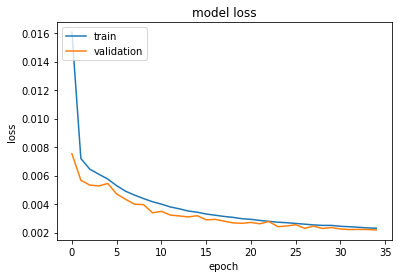

In [15]:
#plotting loss and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
#testing the performance of the model over a stocks
xtest = data[['A']]
xtest, ytest, dates, ztest = dataprocessor.get_testdata(xtest, data2)

smin = np.min(np.min(data[['A']]))
smax = np.min(np.max(data[['A']]))
out = model([xtest, ztest])


ypred = dataprocessor.inverse_transform(out, smin, smax)
ytrue = dataprocessor.inverse_transform(ytest, smin, smax)

yfinal = pd.DataFrame()
yfinal["date"] = dates
yfinal["ytrue"] = ytrue
yfinal["ypred"] = ypred

yfinal.head(20)

<ipython-input-9-e94bd31b3718>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[column] = (data1[column] - smin[column]) / (smax[column] - smin[column])


,date,ytrue,ypred
0,2017-03-30,53.320000,50.071251
1,2017-03-31,52.869999,49.254543
2,2017-04-01,47.099998,49.649883
3,2017-04-04,52.619999,50.725365
4,2017-04-05,56.700001,54.998901
5,2017-04-08,60.130001,60.406815
6,2017-04-10,65.830002,65.634338
7,2017-04-12,66.239998,69.275009
8,2017-04-13,52.330002,58.039631
9,2017-04-17,53.459999,52.029324


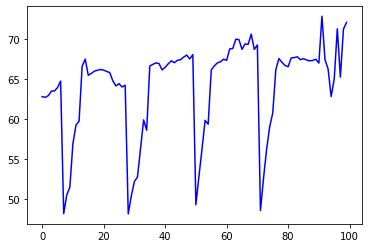

In [17]:
#actual stock values of the selected stock
plt.plot(ytrue[100:200], color = "blue")

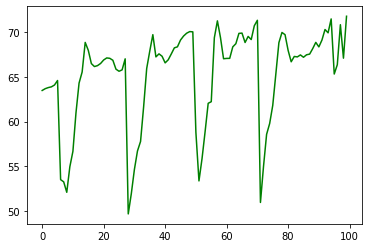

In [18]:
#predicted values of the stock
plt.plot(ypred[100:200], color = "green")


In [19]:
#saving the model
model.save("stockmodel.h5")

<h3>Part III: Testing the model / performance Evaluation</h3>

In [20]:
#load the trained model
model_final = load_model("stockmodel.h5")

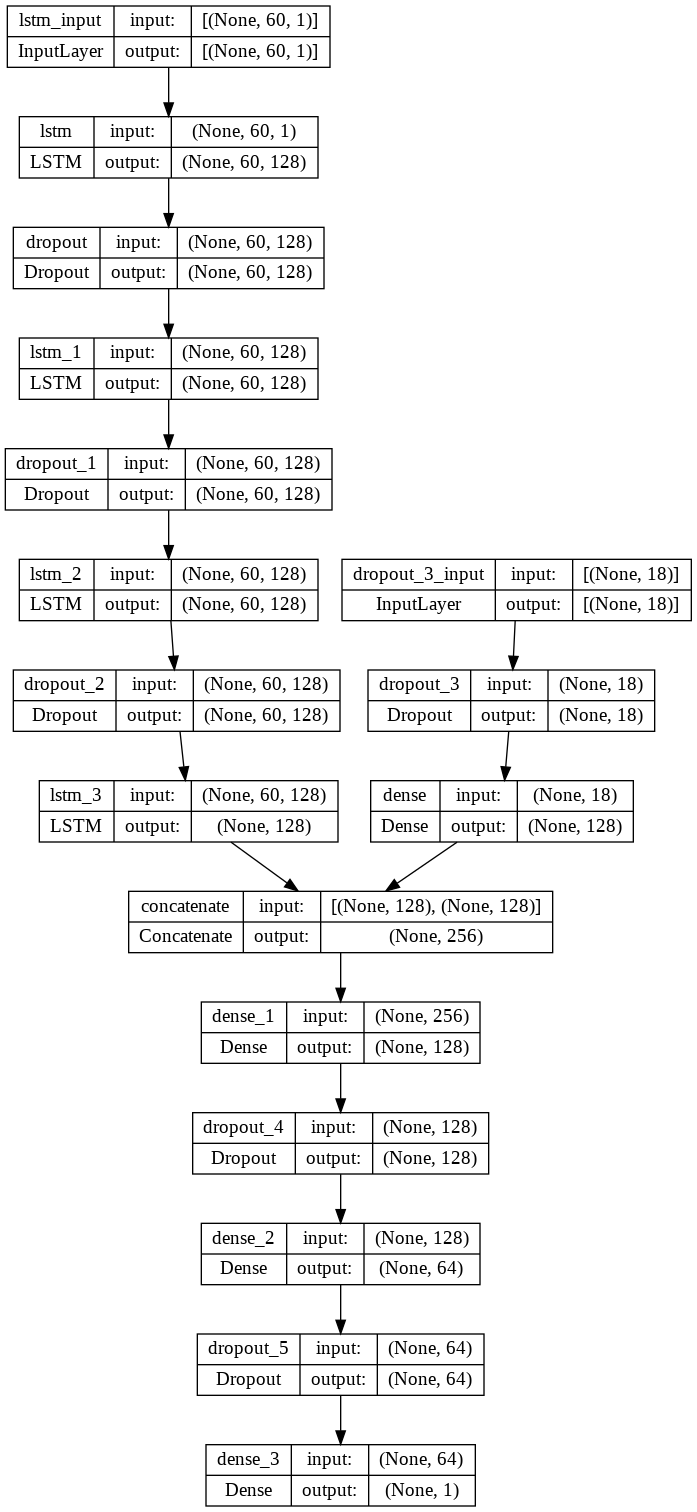

In [21]:
#description of the model
from keras.utils.vis_utils import plot_model
plot_model(model_final, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
#make predictions on the test data
xtest, ytest, dates, ztest = dataprocessor.get_testdata(testData, data2)

out = model_final.predict([xtest, ztest], batch_size = 256)
ytest.shape, out.shape

<ipython-input-9-e94bd31b3718>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[column] = (data1[column] - smin[column]) / (smax[column] - smin[column])


275/275 [==============================] - 4s 11ms/step


((70150, 1), (70150, 1))

In [23]:
#performance metric : Mean square Error
mse = keras.losses.MeanSquaredError()
print("Mean Squared Error : ", mse(ytest, out).numpy())


Mean Squared Error :  0.0021732561


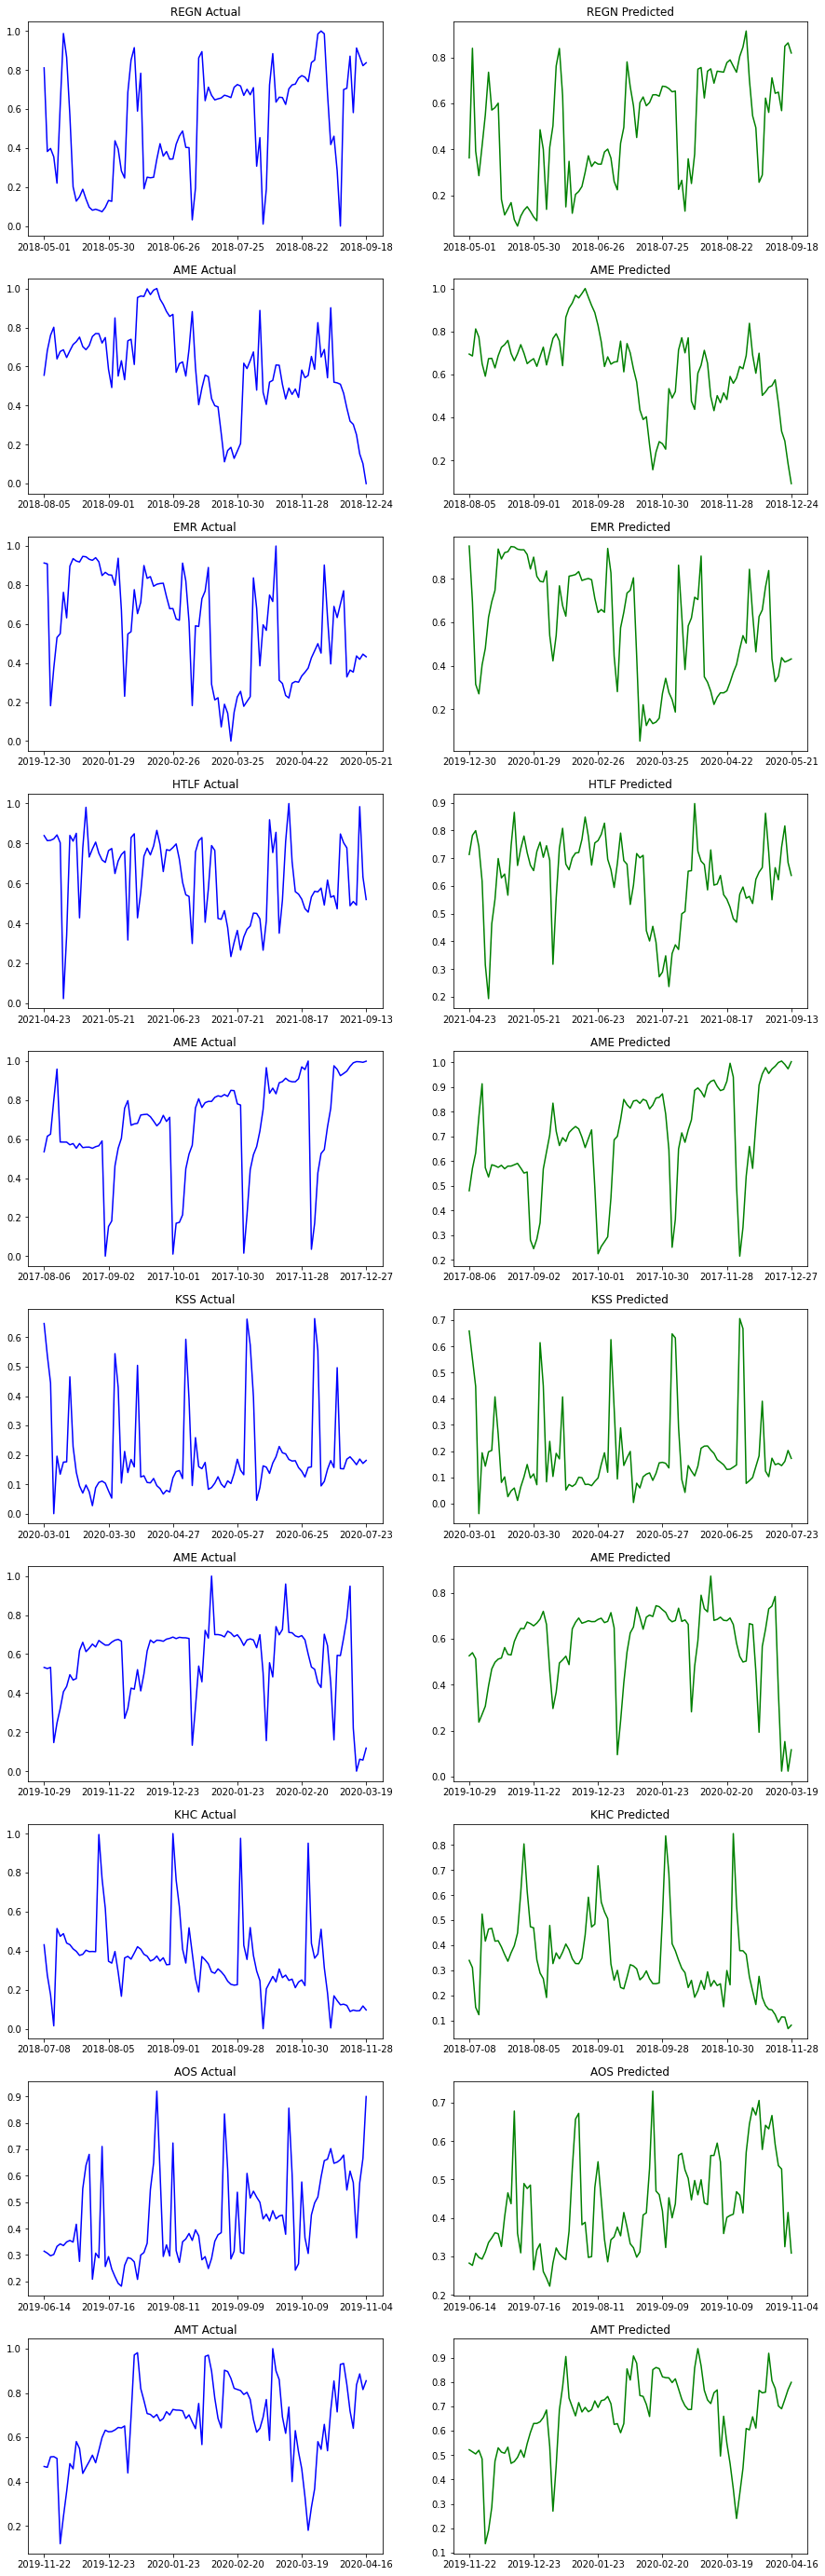

In [25]:
#stock predictions over some test data with our model
columns = list(testData.columns)
selected = random.choices(columns, k=10)
smins = testData.min(axis = 0)
smaxs = testData.max(axis = 0)
figure, axis = plt.subplots(10, 2, figsize=(15, 50))
for i in range(10):
  v = random.randint(0, 1300)
  dt = pd.DataFrame(testData[selected[i]].iloc[v:v+161])
  xtest2, ytest2, dates2, ztest2 = dataprocessor.get_testdata(dt, data2)

  smin = np.min(xtest2)
  smax = np.max(xtest2)


  out = model_final.predict([xtest2, ztest2], batch_size = 128, verbose=0)

  out = out * (smaxs[selected[i]] - smins[selected[i]]) + (smins[selected[i]])
  ytest2 = ytest2 * (smaxs[selected[i]] - smins[selected[i]]) + (smins[selected[i]])
  
  axis[i, 0].plot(dates[v:v+101], ytest2, color="blue", label = "actual")
  axis[i, 0].set_title(selected[i] + " Actual")
  axis[i, 0].xaxis.set_ticks(dates[v:v+101][::20])

  axis[i, 1].plot(dates[v:v+101], out, color="green", label = "predicted")
  axis[i, 1].set_title(selected[i] + " Predicted")
  axis[i, 1].xaxis.set_ticks(dates[v:v+101][::20])